In [1]:
import cv2
import matplotlib
import numpy as np
import os, random
from matplotlib import pyplot as plt
# Import interaction widgets and functions
from ipywidgets import interact, interactive, interact_manual



# Local histogram-specific imports from skimage
from skimage.morphology import disk
from skimage.morphology import ball
from skimage.filters import rank

from skimage import data, img_as_float
from skimage import exposure


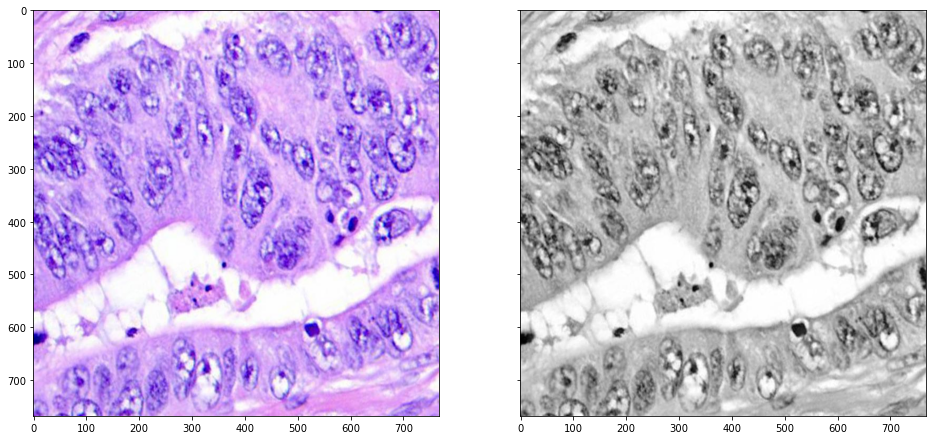

In [2]:
# Load the image in color (OpenCV standard = BGR)
orig_ca = cv2.imread("data\\colon_image_sets\\colonca4667.jpeg", cv2.IMREAD_COLOR)
# Convert to RGB
orig_ca = cv2.cvtColor(orig_ca, cv2.COLOR_BGR2RGB)

# Load the image in grayscale
gray_ca = cv2.imread("data\\colon_image_sets\\colonca4667.jpeg", cv2.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(orig_ca)
ax[1].imshow(gray_ca, 'gray')


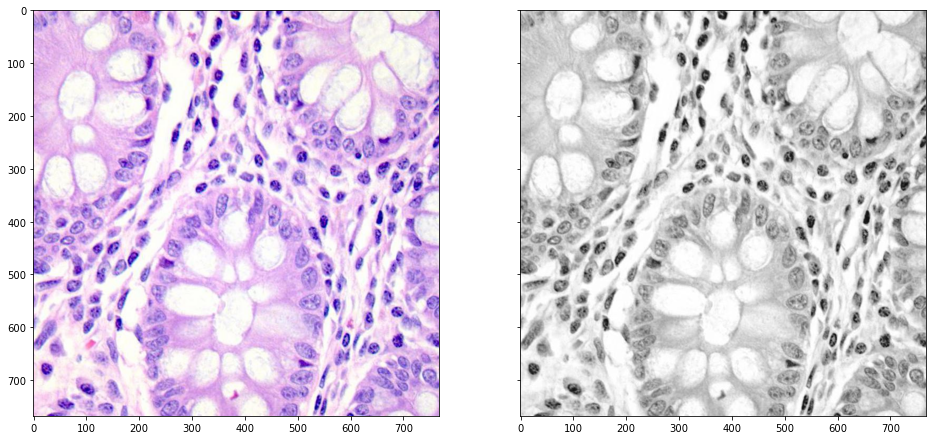

In [3]:
# Load the image in color (OpenCV standard = BGR)
orig_n = cv2.imread("data\\colon_image_sets\\colonn4667.jpeg", cv2.IMREAD_COLOR)
# Convert to RGB
orig_n = cv2.cvtColor(orig_n, cv2.COLOR_BGR2RGB)

# Load the image in grayscale
gray_n = cv2.imread("data\\colon_image_sets\\colonn4667.jpeg", cv2.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(orig_n)
ax[1].imshow(gray_n, 'gray')


In [4]:
modes = ['cv2.THRESH_BINARY',
         'cv2.THRESH_BINARY_INV',
         'cv2.THRESH_TRUNC',
         'cv2.THRESH_TOZERO',
         'cv2.THRESH_TOZERO_INV']



def my_threshold(thresh, modeStr, size_open, size_close):
    global gray_n
    global gray_ca
    
    img = gray_n
    img_ca = gray_ca
    
    mode = eval(modeStr)
    
    th, dst = cv2.threshold(img, thresh, 255, mode)
    th_ca, dst_ca = cv2.threshold(img_ca, thresh, 255, mode)
    
    
    kernel1 = np.ones((size_open,size_open),np.uint8)
    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(size_open,15))
    kernel2 = np.ones((size_close,size_close),np.uint8) 
    opening = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel1)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel2)
    
    opening_ca = cv2.morphologyEx(dst_ca, cv2.MORPH_OPEN, kernel1)
    closing_ca = cv2.morphologyEx(opening_ca, cv2.MORPH_CLOSE, kernel2)

    fig, axes = plt.subplots(2, 4, figsize=(16, 12), sharex=True, sharey=True)
#     ax = axes.ravel()
    plt.subplot(2,4,1)
    plt.imshow(img, 'gray')
    
    plt.subplot(2,4,2)
    plt.imshow(dst, 'gray')
    
    plt.subplot(2,4,3)
    plt.imshow(opening, 'gray')
    
    plt.subplot(2,4,4)
    plt.imshow(closing, 'gray') 
    
    plt.subplot(2,4,5)
    plt.imshow(img_ca, 'gray')
    
    plt.subplot(2,4,6)
    plt.imshow(dst_ca, 'gray')
    
    plt.subplot(2,4,7)
    plt.imshow(opening_ca, 'gray')
    
    plt.subplot(2,4,8)
    plt.imshow(closing_ca, 'gray')
    
    print('n = ', cv2.countNonZero(closing))
    print('ca = ', cv2.countNonZero(closing_ca))

    
#     return dst

In [5]:
interactive(my_threshold, modeStr=modes, thresh=(1, 255), size_open=(5, 55), size_close=(5, 55,))


interactive(children=(IntSlider(value=128, description='thresh', max=255, min=1), Dropdown(description='modeSt…

In [6]:
def funcao(img, thresh, size_open, size_close):
   
    mode = eval('cv2.THRESH_BINARY')
    
    th, dst = cv2.threshold(img, thresh, 255, mode)
    
    
    kernel1 = np.ones((size_open,size_open),np.uint8)
    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(size_open,15))
    kernel2 = np.ones((size_close,size_close),np.uint8) 
    opening = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel1)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel2)
    
#     fig, axes = plt.subplots(2, 4, figsize=(16, 12), sharex=True, sharey=True)
# #     ax = axes.ravel()
#     plt.subplot(1,2,1)
#     plt.imshow(img, 'gray')
    
#     plt.subplot(1,4,2)
#     plt.imshow(dst, 'gray')
    
#     plt.subplot(1,4,3)
#     plt.imshow(opening, 'gray')
    
#     plt.subplot(1,2,2)
#     plt.imshow(closing, 'gray') 
#     plt.show()
    
    blurred = cv2.medianBlur(opening, 9)

    # blurred = cv2.equalizeHist(blurred)

    # CLAHE (Contrast Limited Adaptive Histogram Equalization) 
    # create a CLAHE object (Arguments are optional)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    blurred = clahe.apply(blurred)

    cimg = cv2.cvtColor(blurred,cv2.COLOR_GRAY2BGR)

    # Create an edge image with the OpenCV canny implementation
    edges = cv2.Canny(blurred,threshold1=10,threshold2=400,apertureSize=5, L2gradient=True)
    # apertureSize is the aperture size for the Sobel edge detection operator

    circles = cv2.HoughCircles(edges,
                               cv2.HOUGH_GRADIENT,
                               dp=5,
                               minDist=50,
                               param1=200,
                               param2=100,
                               minRadius=1,
                               maxRadius=25)

    circles = np.uint16(np.around(circles))

    h = 0
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
        h += 1

    
#     print('white_pixels = ', cv2.countNonZero(closing))
# cv2.countNonZero(closing),
    
    return  h

In [ ]:
path = "data\\colon_image_sets\\"

for i in range(10):
    rnd = random.choice(os.listdir(path))
    
    img = cv2.imread(path + rnd, cv2.IMREAD_GRAYSCALE)
    print(rnd)
    print("\t", rnd[5], funcao(img, 215, 10, 5))


In [11]:
img = cv2.imread("data\\colon_image_sets\\colonn409.jpeg", cv2.IMREAD_GRAYSCALE)

size_open, size_close = 7, 5

mode = eval('cv2.THRESH_BINARY')

th, dst = cv2.threshold(img, 220, 255, mode)

kernel1 = np.ones((size_open,size_open),np.uint8)
kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(size_open,15))
kernel2 = np.ones((size_close,size_close),np.uint8) 
opening = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel1)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel2)

In [95]:
def funcao_2(img, thresh, size_open, size_close):
   
    mode = eval('cv2.THRESH_BINARY')
    
    th, dst = cv2.threshold(img, thresh, 255, mode)
    
    
    kernel1 = np.ones((size_open,size_open),np.uint8)
    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(size_open,15))
    kernel2 = np.ones((size_close,size_close),np.uint8) 
    opening = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel1)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel2)

    img = closing
    thresh = closing
    # thresh = cv2.adaptiveThreshold(thresh, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 211, 0)
    count, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh)
    for i in range(1,count):
        img = cv2.circle(img, (int(centroids[i,0]), int(centroids[i,1])), 10, (0, 0, 0, 0), 5)

    e = 0
    for item in stats:
        if item[4] > 1100:
            e +=1 
#     print(e)
    # plt.imshow(thresh, 'gray')
#     plt.imshow(img, 'gray')
    
    return e

In [98]:
path = "data\\colon_image_sets\\"

lista_c = []
lista_n = []
for i in range(10000):
    rnd = random.choice(os.listdir(path))
    
    img = cv2.imread(path + rnd, cv2.IMREAD_GRAYSCALE)
    if rnd[5] == 'c':
        lista_c.append(funcao_2(img, 230, 10, 6))
    else:
        lista_n.append(funcao_2(img, 230, 10, 6))
    
    

    
print('c = ', sum(lista_c)/len(lista_c))
print('n = ', sum(lista_n)/len(lista_n))


c =  9.301030927835052
n =  24.72621359223301


In [101]:
path = "data\\colon_image_sets\\"

lista_c = []
lista_n = []
for images in os.listdir(path):
    if (images.endswith(".jpeg")):
        img = cv2.imread(path + images, cv2.IMREAD_GRAYSCALE)
        if images[5] == 'c':
            lista_c.append(funcao_2(img, 230, 10, 6))
        else:
            lista_n.append(funcao_2(img, 230, 10, 6))
            
print('c = ', sum(lista_c)/len(lista_c))
print('n = ', sum(lista_n)/len(lista_n))

c =  9.469
n =  24.5246


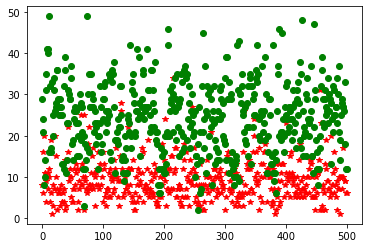

In [103]:
plt.plot(lista_c[:500],'r*', lista_n[:500], 'go')
plt.show()

In [124]:
print("Matriz de Confusão:")
limiar = 17
tp = sum(num < limiar for num in lista_c)
fn = sum(num >= limiar for num in lista_c)
fp = sum(num < limiar for num in lista_n)
tn = sum(num >= limiar for num in lista_n)

print("TP:", tp)
print("FN:", fn)
print("FP:", fp)
print("TN:", tn)
print("Acc:", (tp+tn)/(tp+tn+fp+fn))
print("F1 Score:", 2*tp/(2*tp + fp + fn))

Matriz de Confusão:
TP: 4438
FN: 562
FP: 859
TN: 4141
Acc: 0.8579
F1 Score: 0.8619986403806934


In [125]:
dici = {}
for i in range(10, 30):
    lista = []
    limiar = i
    tp = sum(num < limiar for num in lista_c)
    fn = sum(num >= limiar for num in lista_c)
    fp = sum(num < limiar for num in lista_n)
    tn = sum(num >= limiar for num in lista_n)
    acc = (tp+tn)/(tp+tn+fp+fn)
    f1_scr = 2*tp/(2*tp + fp + fn)
    lista.append(acc)
    lista.append(f1_scr)
    dici[i] = lista

In [127]:
dici

{10: [0.7632, 0.7082306554953179],
 11: [0.7979, 0.7650819481576194],
 12: [0.8217, 0.8022623932571809],
 13: [0.8402, 0.83010844142037],
 14: [0.8517, 0.8475691232397985],
 15: [0.8575, 0.8579120550403829],
 16: [0.8579, 0.8619986403806934],
 17: [0.8584, 0.8658074298711145],
 18: [0.8514, 0.8620241411327763],
 19: [0.8463, 0.8600054649785955],
 20: [0.8338, 0.8515541264737406],
 21: [0.8206, 0.8427695004382121],
 22: [0.8032, 0.83113094216578],
 23: [0.7875, 0.8212633526789469],
 24: [0.7704, 0.8102165647214415],
 25: [0.7503, 0.7976335197341762],
 26: [0.7275, 0.7836443032949583],
 27: [0.7061, 0.7708739377874796],
 28: [0.6811, 0.7563230686941239],
 29: [0.6576, 0.7433283358320839]}